In [1]:
import util_thm
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import os

# Reading data
In case that we get different EoS using the same folder parameters in the future, I'll also keep track of the EoS file. For this I think the file modification time is sufficient.

Unfinished runs are detected by mismatches in the length of beta.

Folder parameters deserves attention:
* $\mu$, $V$ and $shift$ are things we expect to be different in a folder. All the other parameters should be the same; I include them in `folder_params_shared` and check for every folder.
    * Among them, $\mu$ is additionally saved in `data_in_measurements["mu"]`. I check that this indeed matches the one specified in the folder name.
    * For $V$ and $shift$, I don't do the filtering until all the data are loaded.

In [ ]:
# I had to keep the data files in the download folder, otherwise the folder names are too long
data_folder = Path(r"C:\Users\ken92\Downloads\Shao-Wen Data")
scan_name = Path(r"sawtooth_spinless_I_L25_chi64.tar")
scan_folder = Path(data_folder, scan_name)
assert scan_folder.exists()

subfolder_list = [f for f in scan_folder.iterdir() if f.is_dir()]
print(f"found {len(subfolder_list)} folders")

first_betas = None
folder_params_shared = None
records_EoS = []
for i_f, sf_path in enumerate(subfolder_list):
    # Load data and store them as panda data rows
    filepath = Path(sf_path, "measurements.pkl")
    assert filepath.is_file()
    with open(filepath, "rb") as f:
        file_content = pickle.load(f)

    try:
        folder_params = util_thm.parse_folder_name(sf_path)
        
        # Check mu consistency between folder name and file
        mu = file_content['mu']
        if not np.isclose(mu, folder_params['mu']):
            raise(ValueError(f"mu_folder = {folder_params['mu']} doesn't agree with mu_file = {mu}"))
        else:
            folder_params.pop("mu")
        
        # Check shared folder parameters
        V = folder_params.pop("V")
        shift = folder_params.pop("shift")
        if folder_params_shared is None:
            folder_params_shared = folder_params.copy()
        else:
            if folder_params != folder_params_shared:
                print(folder_params)
                print(folder_params_shared)
                raise(ValueError("mismatch in folder parameters"))

        # Save data
        for i_b, beta in enumerate(file_content['betas']):
            S2, n_avg, energy, eps, ov, max_chi, trace, runtime = file_content['data'][i_b, :]
            records_EoS.append({
                "mu": file_content['mu'],
                "beta": beta,
                "S2": S2,
                "n_avg": n_avg,
                "energy": energy,
                "eps": eps,
                "ov": ov,
                "max_chi": max_chi,
                "trace": trace,
                "runtime": runtime,
                "file_mtime": os.path.getmtime(filepath),
                "V": V,
                "shift": shift
            } | folder_params)
    except ValueError as e:
        print(filepath)
        print(file_content['data'])
        raise(e)

    # Check beta length and print warnings if they don't look right
    if first_betas is None:   # assuming that the first subfolder has the right length of data
        first_betas = file_content['betas']
        continue
    else:
        len_good = (len(file_content['betas']) == len(first_betas))      # length is good
        if len_good: # content is also good
            if np.allclose(file_content['betas'], first_betas):
                continue
    print(f"beta doesn't agree for {filepath}")
    print(f"getting {file_content['betas']}")

found 88 folders


## Filter parameters using Dataframe
Currently I only consider joined systems with the same interaction strength everywhere.

### Specify filter parameters

In [3]:
V_model = 1.
shift_model = -2.
filter_params = {"V": V_model, "shift": shift_model}

In [4]:
L_subregion = folder_params["L"]    # We checked consistency for this one
print(f"Each subregion contains {L_subregion} unit cells")

Each subregion contains 25 unit cells


In [5]:
df_all_data = pd.DataFrame.from_records(records_EoS)
df_filtered = df_all_data.query(f"(V == {V_model}) & (shift == {shift_model}) & (L == {L_subregion})")
idx_list = ["mu", "beta"]
df_filtered = df_filtered.set_index(idx_list).sort_index()

df_filtered

S2     n_avg    energy           eps        ov  max_chi  \
mu   beta                                                                  
-1.0 0.0   0.693147  0.500000  0.365000  0.000000e+00  1.000000      1.0   
     0.1   0.682902  0.466484  0.256890  5.449057e-16  1.000000     36.0   
     0.2   0.656276  0.438555  0.159561  1.270332e-13  1.000000     64.0   
     0.3   0.618559  0.415604  0.072396  3.004398e-12  1.000000     64.0   
     0.4   0.574005  0.396820 -0.005521  2.385476e-11  1.000000     64.0   
...             ...       ...       ...           ...       ...      ...   
 1.0 19.6  0.010012  0.514621 -1.328655  1.334997e-04  0.999733     64.0   
     19.7  0.009980  0.514641 -1.328657  1.340267e-04  0.999732     64.0   
     19.8  0.009948  0.514662 -1.328658  1.345527e-04  0.999731     64.0   
     19.9  0.009917  0.514682 -1.328659  1.350779e-04  0.999730     64.0   
     20.0  0.009885  0.514701 -1.328660  1.356023e-04  0.999729     64.0   

           trace    runtime    file_mtime    V  ...  spinful interacting   L  \
mu   beta                                       ...                            
-1.0 0.0     1.0   0.000000  1.764024e+09  1.0  ...    False        True  25   
     0.1     1.0   4.810547  1.764024e+09  1.0  ...    False        True  25   
     0.2     1.0  18.466589  1.764024e+09  1.0  ...    False        True  25   
     0.3     1.0  52.927055  1.764024e+09  1.0  ...    False        True  25   
     0.4     1.0  61.760694  1.764024e+09  1.0  ...    False        True  25   
...          ...        ...           ...  ...  ...      ...         ...  ..   
 1.0 19.6    1.0  12.172939  1.764024e+09  1.0  ...    False        True  25   
     19.7    1.0  12.276346  1.764024e+09  1.0  ...    False        True  25   
     19.8    1.0  12.357138  1.764024e+09  1.0  ...    False        True  25   
     19.9    1.0  12.477027  1.764024e+09  1.0  ...    False        True  25   
     20.0    1.0  12.457816  1.764024e+09  1.0  ...    False        True  25   

             t        tp  ymax  dBeta  Nsteps  chi           svd  
mu   beta                                                         
-1.0 0.0   1.0  1.414214     0    0.1     200   64  1.000000e-08  
     0.1   1.0  1.414214     0    0.1     200   64  1.000000e-08  
     0.2   1.0  1.414214     0    0.1     200   64  1.000000e-08  
     0.3   1.0  1.414214     0    0.1     200   64  1.000000e-08  
     0.4   1.0  1.414214     0    0.1     200   64  1.000000e-08  
...        ...       ...   ...    ...     ...  ...           ...  
 1.0 19.6  1.0  1.414214     0    0.1     200   64  1.000000e-08  
     19.7  1.0  1.414214     0    0.1     200   64  1.000000e-08  
     19.8  1.0  1.414214     0    0.1     200   64  1.000000e-08  
     19.9  1.0  1.414214     0    0.1     200   64  1.000000e-08  
     20.0  1.0  1.414214     0    0.1     200   64  1.000000e-08  

[4221 rows x 22 columns]

## Plots
Even for finite interaction strengths, we still see a trace of the flat band in the $S_{2, avg}$ plot. For example, for the $V = 1$, shift $= 2$ single layer sawtooth, we see an enhancement in entropy around $\mu = 0.5$. I would have naively guessed that this should happen at $\mu = 0.25$ instead by looking at the completely localized states (CLS):
* The wave function of CLS lives on two neighboring teeth, and has values of $1 / \sqrt(2)$ on the shared A site, and $1 / 2$ on the two B sites.
    * i.e. there's half a particle on the A site and a quarter of a particle each on the B sites
* Each of the link then gets an energy of $1/2 \cdot 1/4 \cdot V = 1/8$.
* There are two links, so the shift in energy for each CLS is $1/8 \cdot 2 = 1/4$.

In [6]:
mu_vals  = df_filtered.index.get_level_values("mu").unique().to_numpy()
beta_vals = df_filtered.index.get_level_values("beta").unique().to_numpy()
n_grid = df_filtered["n_avg"].unstack("beta").loc[mu_vals, beta_vals].to_numpy()    # particle per site
s2_grid = df_filtered["S2"].unstack("beta").loc[mu_vals, beta_vals].to_numpy()       # Renyi 2-entropy per particle
e_grid = df_filtered["energy"].unstack("beta").loc[mu_vals, beta_vals].to_numpy()   # energy per particle
eps_grid = df_filtered["eps"].unstack("beta").loc[mu_vals, beta_vals].to_numpy()    # sum of all discarded Schmidt values squared
ov_grid = df_filtered["ov"].unstack("beta").loc[mu_vals, beta_vals].to_numpy()      # lower bound for the overlap

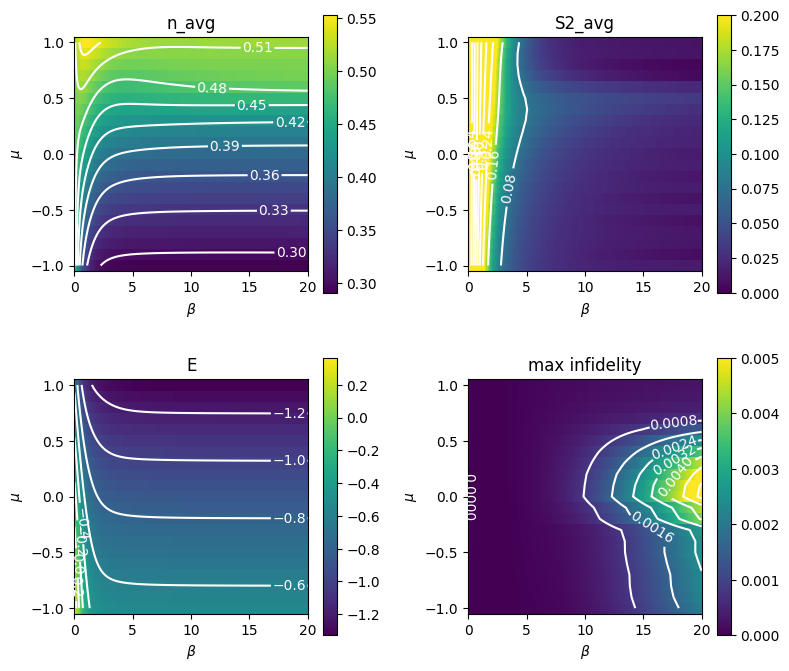

In [7]:
fig_ns, axes_ns = plt.subplots(2, 2, figsize = (8, 7))
for ax, vals, str_label, clim in zip(axes_ns.flatten(),
                    [n_grid, s2_grid, e_grid, 1 - ov_grid],
                    ["n_avg", "S2_avg", "E", "max infidelity"],
                    [None, (0., 0.2), None, (0, 0.005)]):
    img = ax.pcolormesh(beta_vals, mu_vals, vals, clim = clim)
    ax.set_box_aspect(1)
    ax.set_title(str_label)
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"$\mu$")
    cntr = ax.contour(beta_vals, mu_vals, vals, colors = "white", linestyles = "solid", levels = 8)
    ax.clabel(cntr, inline = True)
    fig_ns.colorbar(img, ax = ax)
fig_ns.tight_layout()

# Actual calculations
$(\mu_s, \mu_r, \beta) \rightarrow (N_{tot}, S_{tot})$, where I additionally define
* $V_{offset} = \mu_r - \mu_s$
* $\mu \equiv \mu_r$ --- this one is somewhat arbitrary. Effectively, I'm assuming that $V_{offset}$ is a potential that only increases the potential energy in the system region, while leaving the reservoir region intact. This is the case for our experimental setup, since our DMD light is blue-detuned.
* $n = N_{tot} / 4L$

(Take $L_s = L_r = L$ for now, where $L$ is the number of unit cells, so there are $2L$ sites in each subregion)

Goal: given our equations of state $n(\mu, \beta)$ and $s_2(\mu, \beta)$, achieve some filling factor $n_s$ in the system for different $(N_{tot}, S_{tot})$
(This also fixes $N_r = N_{tot} - 2 n_s L$, or equivalently $n_r = 2n - n_s$)
1. Find $\mu_{s, r} = \mu(\beta) |_{n(\mu, \beta) = n_{s, r}}$ by inverting $n(\mu, \beta)$. I can do this for all $\beta$.
2. Find $s_2(\mu_{s, r}, \beta)$. As I vary $\beta$ I should get a smooth change in $S_2 = 2 L (s_2(\mu_s) + s_2(\mu_r))$, so the scan in $S_{tot}$ comes for free.
3. Do this for different $N_{tot}$. Now I've done a scan in the $(N, S)$ space.

## $N_{tot}$ and $S_{tot}$ matching
We'll see how well ChatGPT implement this algorithm in 48 seconds.

### Helper functions

In [8]:
def invert_n_to_mu(mu_vals, beta_vals, n_grid, n_target, fill_value = np.nan):
    """
    For each beta, find mu such that n(mu, beta) = n_target using 1D interpolation
    along the mu-axis.

    Parameters
    ----------
    mu_vals : 1D array, shape (N_mu,)
    beta_vals : 1D array, shape (N_beta,)
    n_grid : 2D array, shape (N_mu, N_beta)
        n_grid[i, j] = n(mu_vals[i], beta_vals[j])
    n_target : float
        Desired filling n_s or n_r.
    fill_value : float
        Value to put where n_target is outside the n(mu, beta) range.

    Returns
    -------
    mu_of_beta : 1D array, shape (N_beta,)
        mu(beta) such that n(mu(beta), beta) ≈ n_target. Entries may be NaN.
    """
    mu_vals = np.asarray(mu_vals)
    beta_vals = np.asarray(beta_vals)
    n_grid = np.asarray(n_grid)

    if n_grid.shape != (mu_vals.size, beta_vals.size):
        raise ValueError("n_grid must have shape (len(mu_vals), len(beta_vals)).")

    mu_of_beta = np.full(beta_vals.shape, fill_value, dtype=float)

    for j in range(beta_vals.size):
        n_vs_mu = n_grid[:, j]

        # Check if target is within the range for this beta
        n_min, n_max = np.nanmin(n_vs_mu), np.nanmax(n_vs_mu)
        if not (n_min <= n_target <= n_max):
            # cannot invert safely at this beta - can add extrapolation in the future
            continue

        # Ensure monotonicity for np.interp: if decreasing, flip both arrays
        # (We know that n has to increase with larger mu though, so most likely this doesn't do anything)
        if n_vs_mu[0] > n_vs_mu[-1]:
            n_sorted = n_vs_mu[::-1]
            mu_sorted = mu_vals[::-1]
        else:
            n_sorted = n_vs_mu
            mu_sorted = mu_vals

        mu_of_beta[j] = np.interp(n_target, n_sorted, mu_sorted)

    return mu_of_beta

In [9]:
def s2_at_mu(mu_vals, beta_vals, s2_grid, mu_of_beta, fill_value=np.nan):
    """
    Given mu(beta), get s2(mu(beta), beta) by 1D interpolation in mu for each beta.

    Parameters
    ----------
    mu_vals : 1D array, shape (N_mu,)
    beta_vals : 1D array, shape (N_beta,)
    s2_grid : 2D array, shape (N_mu, N_beta)
    mu_of_beta : 1D array, shape (N_beta,)

    Returns
    -------
    s2_of_beta : 1D array, shape (N_beta,)
    """
    mu_vals = np.asarray(mu_vals)
    beta_vals = np.asarray(beta_vals)
    s2_grid = np.asarray(s2_grid)
    mu_of_beta = np.asarray(mu_of_beta)

    if s2_grid.shape != (mu_vals.size, beta_vals.size):
        raise ValueError("s2_grid must have shape (len(mu_vals), len(beta_vals)).")

    s2_of_beta = np.full(beta_vals.shape, fill_value, dtype=float)

    for j, mu in enumerate(mu_of_beta):
        if np.isnan(mu):
            continue

        s2_vs_mu = s2_grid[:, j]
        # interpolate in mu; do NOT extrapolate beyond the grid
        s2_of_beta[j] = np.interp(mu, mu_vals, s2_vs_mu,
                                  left=fill_value, right=fill_value)

    return s2_of_beta

### Scan $N_{tot}$

In [10]:
idx_beta_scan = (beta_vals >= 2.)       # Otherwise the contours will be concentrated at small beta where things are boring
# idx_beta_scan = (beta_vals >= -1.)      # All beta
beta_scan = beta_vals[idx_beta_scan]
N_tot_arr = np.arange(30, 50)
n_s_tar = 0.4   # target filling in the system

In [11]:
N_beta = beta_scan.size
N_Ntot = N_tot_arr.size

mu_s_all  = np.full((N_Ntot, N_beta), np.nan)
mu_r_all  = np.full((N_Ntot, N_beta), np.nan)
s2_s_all  = np.full((N_Ntot, N_beta), np.nan)
s2_r_all  = np.full((N_Ntot, N_beta), np.nan)
S2_tot_all = np.full((N_Ntot, N_beta), np.nan)
n_r_arr   = np.full(N_Ntot, np.nan)

for k, N_tot in enumerate(N_tot_arr):
    # global filling n and reservoir filling n_r
    n_global = N_tot / (4.0 * L_subregion)
    n_r = 2.0 * n_global - n_s_tar   # equivalently: N_tot/2L - n_s
    n_r_arr[k] = n_r

    # 1) invert n(mu, beta) to get mu_s(beta) and mu_r(beta)
    mu_s = invert_n_to_mu(mu_vals, beta_scan, n_grid[:, idx_beta_scan], n_s_tar)
    mu_r = invert_n_to_mu(mu_vals, beta_scan, n_grid[:, idx_beta_scan], n_r)

    mu_s_all[k, :] = mu_s
    mu_r_all[k, :] = mu_r

    # 2) evaluate s2 at those mus
    s2_s = s2_at_mu(mu_vals, beta_scan, s2_grid[:, idx_beta_scan], mu_s)
    s2_r = s2_at_mu(mu_vals, beta_scan, s2_grid[:, idx_beta_scan], mu_r)

    s2_s_all[k, :] = s2_s
    s2_r_all[k, :] = s2_r

    # 3) total S2
    S2_tot_all[k, :] = L_subregion * (s2_s + s2_r)

dmu_all = mu_r_all - mu_s_all
mu_glob_all = mu_r_all

We are interested in knowing when we can realize $s_r > s_s$. I'll define a dimensionless figure of merit

$\varsigma \equiv s_s / s - 1 = (s_s - s_r) / (s_s + s_r)$ (assume $L_r = L_s$)

that measures the decrease in entropy, measured in entropy per particle if there were no offset. $\varsigma < 0$ indicates cooling effect.

In [12]:
varsigma_all = (s2_s_all - s2_r_all) / (s2_s_all + s2_r_all)
min_varsigma = np.nanmin(varsigma_all.flatten())    # bset cooling obtained

# masking arrays derived from varsigma
varsigma_all_nonan = np.nan_to_num(varsigma_all)
mask_bool_cooling = (varsigma_all_nonan < 0)
mask_alpha_cooling = np.minimum(varsigma_all_nonan, 0.) / min_varsigma

In [13]:
min_varsigma

np.float64(-0.24736261901644924)

### Plots
The amount of cooling is, of course, shaded in red.
* $s_s$ plot is by definition boring, since $N_{tot}$ doesn't change $n_s$.
* $s_r$ plot has more feature because $n_r$ depends on $N_{tot}$.
* $S_{tot}$
* $\mu$
* $V_{offset}$ tells us the required offset we need to achieve $n_s$ in the system.

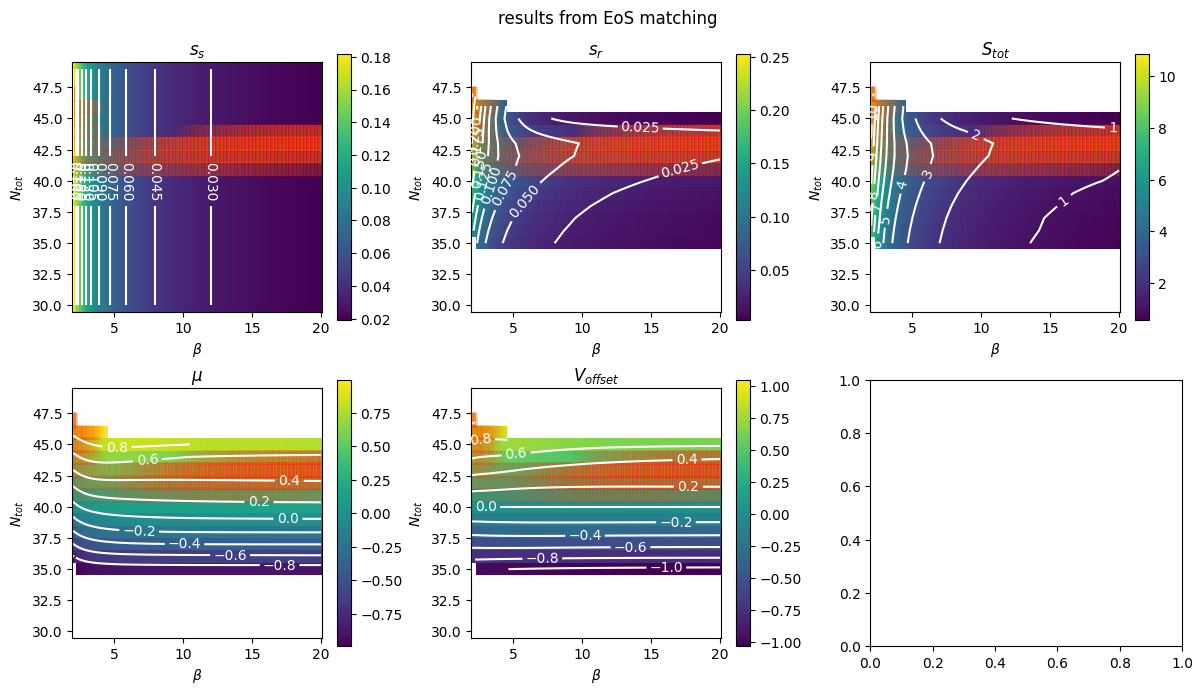

In [14]:
fig_eos, axes_eos = plt.subplots(2, 3, figsize = (12, 7))
alpha_cooling_max = 0.3
for ax, vals, str_label, clim in zip(axes_eos.flatten(),
                    [s2_s_all, s2_r_all, S2_tot_all, mu_glob_all, dmu_all],
                    [r"$s_s$", r"$s_r$", r"$S_{tot}$", r"$\mu$", r"$V_{offset}$"],
                    [None, None, None, None, None]):
    img = ax.pcolormesh(beta_scan, N_tot_arr, vals, clim = clim, cmap = "viridis")
    ax.set_box_aspect(1)
    ax.set_title(str_label)
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"$N_{tot}$")
    cntr = ax.contour(beta_scan, N_tot_arr, vals, colors = "white", linestyles = "solid", levels = 10)
    ax.clabel(cntr, inline = True)
    fig_eos.colorbar(img, ax = ax)
    ax.pcolormesh(beta_scan, N_tot_arr, np.ones_like(vals), clim = (0, 1), color = "red",
                  alpha = mask_alpha_cooling * alpha_cooling_max)
fig_eos.suptitle("results from EoS matching")
fig_eos.tight_layout()

## Invert the $\beta, S$ conjugate pair
Eventually we are probably more interesed in specifying the system by some initial entropy instead of the final temperature. This requires going from $(n_s; N_{tot}, \beta) \rightarrow (\mu_s, \mu_r, S_{tot})$ to $(n_s; N_{tot}, S_{tot}) \rightarrow (\mu_s, \mu_r, \beta)$. This mapping is unique since $S_{tot}$ is a monotonic function as a function of $\beta$.

I write a semicolon for $n_s$ because it is not really a thermodynamic variable in the usual sense, but not including that gives one the wrong impression that the relation is underdetermined. (i.e. I want to have the same number of values on both side)

I will also replace $\mu_s$ and $\mu_r$ by $V_{offset}$ and $\mu$.

I will do this by storing results in Dataframes, since
1. this allows me to compare scanning different things in the future easily (e.g. $V$, $t_p$)
2. I can save and read the Dataframes using pandas, so I don't have to do the same matching again in the future.

Eventually the actual inversion must be completed by an interpolation.

### Building the matching results Dataframe

In [15]:
records_matching = []
for i_beta, beta in enumerate(beta_scan):
    for i_Ntot, Ntot in enumerate(N_tot_arr):
        records_matching.append({
            "beta": beta,
            "Ntot": Ntot,
            "n_s": n_s_tar,
            "n_r": n_r_arr[i_Ntot],
            "mu_s": mu_s_all[i_Ntot, i_beta],
            "mu_r": mu_r_all[i_Ntot, i_beta],
            "V_offset": dmu_all[i_Ntot, i_beta],
            "mu_glob": mu_glob_all[i_Ntot, i_beta],
            "s2_s": s2_s_all[i_Ntot, i_beta],
            "s2_r": s2_r_all[i_Ntot, i_beta],
            "S2_tot": S2_tot_all[i_Ntot, i_beta],
            "varsigma": varsigma_all[i_Ntot, i_beta],
            "file_mtime": os.path.getmtime(filepath)
        } | filter_params | folder_params_shared)

In [16]:
df_matching_rslt = pd.DataFrame.from_records(records_matching)
df_matching_rslt

,beta,Ntot,n_s,n_r,mu_s,mu_r,V_offset,mu_glob,s2_s,s2_r,...,spinful,interacting,L,t,tp,ymax,dBeta,Nsteps,chi,svd
0,2.0,30,0.4,0.20,-0.066326,NaN,NaN,NaN,0.181833,NaN,...,False,True,25,1.0,1.414214,0,0.1,200,64,1.000000e-08
1,2.0,31,0.4,0.22,-0.066326,NaN,NaN,NaN,0.181833,NaN,...,False,True,25,1.0,1.414214,0,0.1,200,64,1.000000e-08
2,2.0,32,0.4,0.24,-0.066326,NaN,NaN,NaN,0.181833,NaN,...,False,True,25,1.0,1.414214,0,0.1,200,64,1.000000e-08
3,2.0,33,0.4,0.26,-0.066326,NaN,NaN,NaN,0.181833,NaN,...,False,True,25,1.0,1.414214,0,0.1,200,64,1.000000e-08
4,2.0,34,0.4,0.28,-0.066326,NaN,NaN,NaN,0.181833,NaN,...,False,True,25,1.0,1.414214,0,0.1,200,64,1.000000e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3615,20.0,45,0.4,0.50,0.151699,0.776069,0.62437,0.776069,0.019022,0.003069,...,False,True,25,1.0,1.414214,0,0.1,200,64,1.000000e-08
3616,20.0,46,0.4,0.52,0.151699,NaN,NaN,NaN,0.019022,NaN,...,False,True,25,1.0,1.414214,0,0.1,200,64,1.000000e-08
3617,20.0,47,0.4,0.54,0.151699,NaN,NaN,NaN,0.019022,NaN,...,False,True,25,1.0,1.414214,0,0.1,200,64,1.000000e-08
3618,20.0,48,0.4,0.56,0.151699,NaN,NaN,NaN,0.019022,NaN,...,False,True,25,1.0,1.414214,0,0.1,200,64,1.000000e-08


In [17]:
[k for k in folder_params_shared.keys()]

['lattice_geometry',
 'spinful',
 'interacting',
 'L',
 't',
 'tp',
 'ymax',
 'dBeta',
 'Nsteps',
 'chi',
 'svd']

In [18]:
[k for k in filter_params.keys()]

['V', 'shift']

### Save to .csv
I'll treat the following as input parameters:
* All the original folder parameters except for $\mu$.
* $\beta$, $N_{tot}$, $n_s$
* File modification time

A new row of data is added for each input parameters. If an entry with the same input parameters already exists in `csv_path`, we compare if the obtained results agree with the existing ones. If not, we print a warning but leaves the original result unchanged and move on.

If all the input parameters are the same except for the file modification time, the original entry is replaced if `bool_overwrite_older_mtime = True`, or a new row is added if it is `False`.

In [19]:
input_param_cols = [k for k in folder_params_shared.keys()] + [k for k in filter_params.keys()] + [
    "beta",
    "Ntot",
    "n_s",
    "file_mtime",
]

In [20]:
def _match_rows(df, row, cols, float_tol=1e-8):
    """Return boolean mask of rows in df that match `row` on all `cols`."""
    if df.empty or len(cols) == 0:
        return np.zeros(len(df), dtype=bool)

    mask = np.ones(len(df), dtype=bool)

    for col in cols:
        val = row[col]
        s = df[col]

        if pd.api.types.is_numeric_dtype(s):
            # numeric comparison with tolerance, NaN == NaN
            mask &= np.isclose(
                s.to_numpy(dtype=float),
                float(val),
                atol=float_tol,
                rtol=0.0,
                equal_nan=True,
            )
        else:
            # non-numeric: exact match, treating NaN == NaN
            if pd.isna(val):
                mask &= s.isna().to_numpy()
            else:
                mask &= (s == val).to_numpy()

    return mask

def update_eos_csv(
    df_new: pd.DataFrame,
    csv_path: Path,
    param_cols: list,
    bool_overwrite_conflict: bool = False,
    float_tol: float = 1e-8,
):
    """
    Merge df_new into a CSV at csv_path.

    param_cols:
        Columns that define the *input parameters* (including file_mtime).

    Logic per new row:
        - Look for rows in existing CSV with exactly the same param_cols.
        - If none exist: append the new row.
        - If one or more exist:
            * Compare "result columns" (all columns not in param_cols).
            * If any existing row has identical results (within float_tol): do nothing.
            * Otherwise:
                - if bool_overwrite_conflict: replace all matching rows with the new row.
                - else: print a warning, keep existing rows, ignore new row.
    """
    # 1. Load existing CSV, or start from empty
    if os.path.exists(csv_path):
        df_old = pd.read_csv(csv_path)
    else:
        df_old = pd.DataFrame()

    # 2. Align columns between old and new
    all_cols = sorted(set(df_old.columns) | set(df_new.columns))
    df_old = df_old.reindex(columns=all_cols)
    df_new = df_new.reindex(columns=all_cols)

    # "Results" = everything that isn't an input
    result_cols = [c for c in all_cols if c not in param_cols]

    # 3. If no old data, just save and return
    if df_old.empty:
        df_new.to_csv(csv_path, index=False)
        return

    identical_counter = 0
    # 4. Process each new row
    for _, row in df_new.iterrows():
        # rows with the same input parameters (incl. mtime, since it's in param_cols)
        mask_same_inputs = _match_rows(df_old, row, param_cols, float_tol=float_tol)

        if not mask_same_inputs.any():
            df_old = pd.concat([df_old, row.to_frame().T], ignore_index=True)
            continue

        # There are existing rows with identical inputs
        existing_df = df_old.loc[mask_same_inputs]

        # Check if any of them has identical results as well
        mask_identical_results = _match_rows(
            existing_df, row, result_cols, float_tol=float_tol
        )
        if mask_identical_results.any():
            identical_counter += 1
            continue

        # If we get here: same inputs, but *no* row with same results => conflict
        print(
            "WARNING: conflicting results for identical input parameters; "
            f"Ntot={row.get('Ntot')}, beta={row.get('beta')}, "
            f"n_s={row.get('n_s')}, mtime={row.get('file_mtime')}"
        )

        if bool_overwrite_conflict:
            df_old = df_old.drop(existing_df.index)
            df_old = pd.concat([df_old, row.to_frame().T], ignore_index=True)
        else:
            pass

    if identical_counter > 0:
        print(f"{identical_counter} rows already existed in .csv")
    df_old.to_csv(csv_path, index=False)

Check the number of rows existed in .csv if this is something I've run before.

In [21]:
matching_results_folder = Path(r"C:\Users\ken92\Documents\Studies\E5\simulation\E9_simulations\projects\flat_band_cooling\tenpy_results\matching_results")
csv_name = scan_name.stem + "_matching.csv"
csv_path = Path(matching_results_folder, csv_name)

update_eos_csv(
    df_new = df_matching_rslt,
    csv_path = csv_path,
    param_cols = input_param_cols,
    bool_overwrite_conflict = True,
)

3620 rows already existed in .csv


### Actual inversion
I'll split the following sections into a different notebook.

In [22]:
def invert_NS_to_beta_dmu_df(
    df,
    N_target,
    S_target,
    *,
    fill_value=np.nan,
):
    """
    Invert (Ntot, beta) -> (Delta mu, S_tot) to get
    (Ntot, S_tot) -> (beta, Delta mu), using df_matching_rslt.

    Parameters
    ----------
    df : DataFrame
        Must contain columns N_col, S_col, beta_col, dmu_col.
        Each row corresponds to one (Ntot, beta) point.
    N_target : float
        Desired total particle number (must match some Ntot in df).
    S_target : float
        Desired S_tot.
    N_col, S_col, beta_col, dmu_col : str
        Column names in df.
    atol_N : float
        Tolerance when matching N_target to N_col.
    fill_value : float
        Returned when inversion is not possible.

    Returns
    -------
    beta_star, dmu_star : float, float
        beta(N_target, S_target), Delta mu(N_target, S_target),
        or fill_value, fill_value if not found.
    """
    # 1) select rows for this N_target
    N_vals = df["Ntot"].to_numpy(dtype=float)
    mask_N = np.isclose(N_vals, N_target)

    df_N = df.loc[mask_N, ["beta", "S2_tot", "V_offset"]].dropna()
    if df_N.shape[0] < 2:
        # not enough points to interpolate
        return fill_value, fill_value

    # 2) sort by beta (assumed to be your scan parameter)
    df_N = df_N.sort_values("beta")

    beta = df_N["beta"].to_numpy(dtype=float)
    S    = df_N["S2_tot"].to_numpy(dtype=float)
    dmu  = df_N["V_offset"].to_numpy(dtype=float)

    # Optional: remove any NaNs
    mask_finite = np.isfinite(beta) & np.isfinite(S) & np.isfinite(dmu)
    beta, S, dmu = beta[mask_finite], S[mask_finite], dmu[mask_finite]

    if beta.size < 2:
        return fill_value, fill_value

    # 3) check S range for this N
    S_min, S_max = S.min(), S.max()
    if not (S_min <= S_target <= S_max):
        # outside accessible S range for this N
        return fill_value, fill_value

    # 4) invert S(beta) -> beta(S) by interpolation.
    # np.interp needs x to be increasing; enforce monotonic order in S.
    if S[0] > S[-1]:
        S_sorted = S[::-1]
        beta_sorted = beta[::-1]
    else:
        S_sorted = S
        beta_sorted = beta

    beta_star = np.interp(S_target, S_sorted, beta_sorted)

    # 5) now get Delta mu at that beta by interpolating dmu(beta)
    dmu_star = np.interp(beta_star, beta, dmu, left=fill_value, right=fill_value)

    return beta_star, dmu_star


Vectorized version.

In [23]:
def invert_NS_curve_for_fixed_N_df(
    df,
    N_target,
    S_targets,
    *,
    fill_value=np.nan,
):
    """
    Vectorized wrapper: for fixed N_target, invert a list/array of S_targets.

    Returns
    -------
    betas : 1D array
    dmus  : 1D array
        beta(S), Delta mu(S) for each S_targets[i]
    """
    S_targets = np.atleast_1d(S_targets)
    betas = np.full(S_targets.shape, fill_value, dtype=float)
    dmus  = np.full(S_targets.shape, fill_value, dtype=float)

    for i, S_target in enumerate(S_targets):
        betas[i], dmus[i] = invert_NS_to_beta_dmu_df(
            df,
            N_target=N_target,
            S_target=S_target,
            fill_value=fill_value,
        )

    return betas, dmus

In [24]:
S_range = np.linspace(5.0, 15.0, 50)

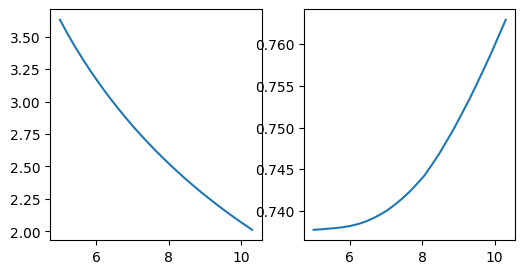

In [28]:
df_filtered = df_matching_rslt.query(f"(V == 1.) & (shift == -2.) & (L == {L_subregion})")
betas_curve, dmus_curve = invert_NS_curve_for_fixed_N_df(
    df_filtered, 45, S_range,
)

fig_Sscan, axs_Sscan = plt.subplots(1, 2, figsize = (6, 3))
axs_Sscan[0].plot(S_range, betas_curve)
axs_Sscan[1].plot(S_range, dmus_curve)
fig_Sscan.tight_layout()